In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

In [4]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

# Sythetic data

In [5]:
import os, sys

In [6]:
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [7]:
#from stay_classification import synthetic_data

from stay_classification.synthetic_data import get_stay_paths, get_journey_path, get_segments

In [300]:
from stay_classification.synthetic_data import get_noise, get_mask

In [422]:
from stay_classification.synthetic_data import get_stay_segs, get_stay, get_seg_info, get_trav

## Journey segments

### times

In [8]:
dsec = 1/3600.0
time = np.arange(0,24,dsec)

### the stays

**Notes**
* specify the beginning and ends of stays, along with location (_ie_ $t_0, t_1, x$, resp.)
* travels connect the endpoints adjacent stays

In [9]:
from stay_classification.synthetic_data import get_stay

stays = [
        get_stay(  0.00,  8.00,-1.00), #home
        get_stay(  8.50, 12.00, 1.10), #work, morning
        get_stay( 12.25, 13.25, 1.60), #lunch
        get_stay( 13.50, 18.00, 1.10), #work, afternoon
        get_stay( 18.50, 20.30,-0.50), #gym
        get_stay( 20.50, 21.50,-2.00), #shopping
        get_stay( 22.00, 24.00, 0.00)  # overnight
    ]

### from stays, get travels, segments, and journey

In [11]:
from stay_classification.synthetic_data import get_stay_segs, get_journey_path, get_segments
from stay_classification.synthetic_data import get_mask, get_noise

t_segs, x_segs = get_stay_segs(stays)

#raw_stays = get_stay_paths(time, stays)

raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))

mask = get_mask(time.size, 0.003, False)

mtime = time[mask]

noisy_journey = get_noise(raw_journey[mask])

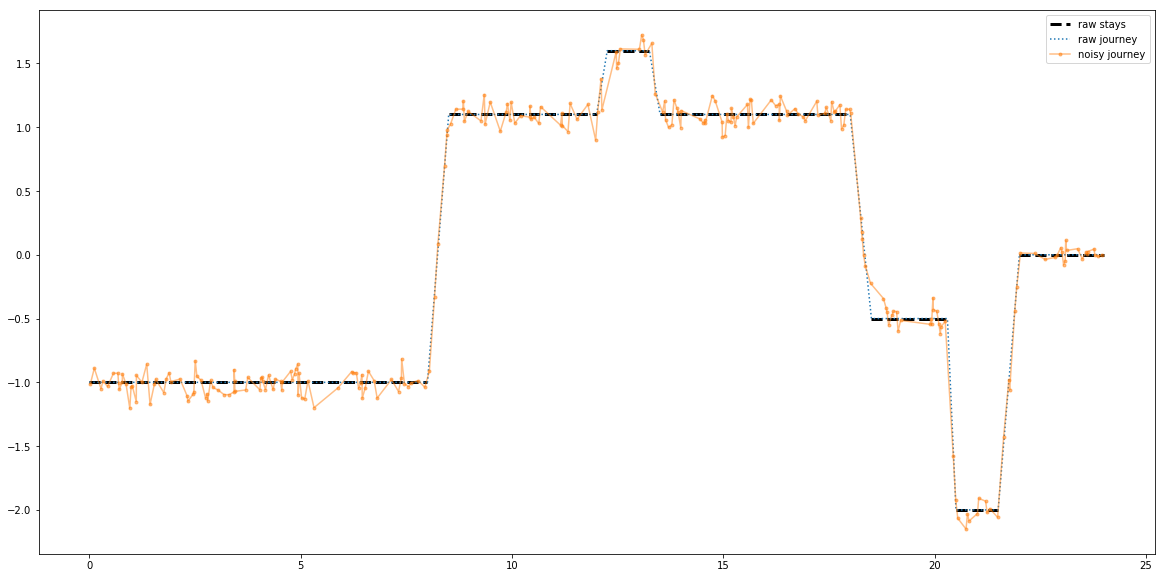

In [12]:
plt.figure(figsize=(20,10))
plt.plot(t_segs, x_segs, 'k--', linewidth=3.0, label='raw stays')
plt.plot(time, raw_journey, ':', label='raw journey')
plt.plot(mtime, noisy_journey, '.-', label='noisy journey', alpha=0.5)
#plt.plot(time[mask], noisy_journey[mask], '.-', label='noisy journey', alpha=0.5)
plt.legend();

### More realistic trajectory 

Here, time points can be repeated, as in mobile phone trajectories based on apparent simultaneous events

In [13]:
rand_range = lambda low, high, size: (high-low)*np.random.rand(size) + low

In [14]:
import pandas as pd

In [15]:
full_times = np.array([])
full_locs = np.array([])

for _ in range(5):
    
    
    t_segs, x_segs = get_stay_segs(stays)

    
    time = np.arange(0,24,dsec)
    #raw_stays = get_stay_paths(time, stays)
    raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))

    # Take a sample for speed up 
    rand_rang = rand_range(0.02,0.05,1)[0]
    #print(rand_rang)
    mask = get_mask(time.size, rand_rang, False)        
    mtime = time[mask]    
    noisy_journey = get_noise(raw_journey[mask])    
    
    # Sample of a sample
    rand_rang = rand_range(0.01,0.06,1)[0]
    #print(rand_rang)
    mask = get_mask(mtime.size, rand_rang, False)                
    full_times = np.hstack([full_times, mtime[mask].transpose()])
    full_locs = np.hstack([full_locs, noisy_journey[mask].transpose()])

df = pd.DataFrame({'t':full_times, 'x':full_locs})
df.sort_values('t', inplace=True)

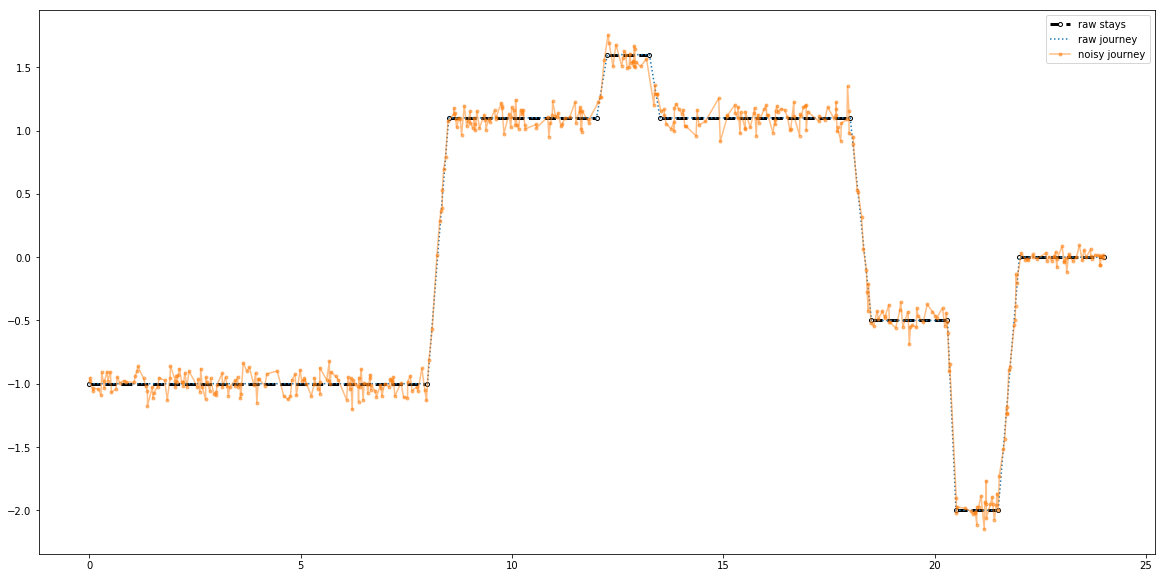

In [17]:
plt.figure(figsize=(20,10))
plt.plot(t_segs, x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='raw stays')
plt.plot(time, raw_journey, ':', label='raw journey')
plt.plot(df.t, df.x, '.-', label='noisy journey', alpha=0.5)
plt.legend();

### TODO: increase the number of duplicate time points

**Goal** have variable, 20--30% duplicates from 2000--5000 events

**Note** There is an array of weights passed in `np.random.choice`
* changes the probab. of picking up specific events in the full array
    * use to change the likelihood for events in individuaal stays

In [143]:
get_frac_outer = lambda size: lambda frac: int(frac*size)

get_frac = get_frac_outer(time.size)

In [144]:
from stay_classification.synthetic_data import get_mask, get_noise

In [568]:
cat_mask = np.empty(0)

test_ = np.random.choice(time, get_frac(0.003), replace=True, )
print(test_.size, len(set(test_)))

# Increasing the number of loops increases the duplicate counts: 2--3 is good for 20--35%
for _ in range(3):
    
    testtime = np.random.choice(test_, get_frac_outer(test_.size)(0.99), replace=True, )    
    print(testtime.size, len(set(testtime)))
    
    testtime = np.random.choice(testtime, get_frac_outer(testtime.size)(0.8), replace=True, )
    
    mask = np.where(np.in1d(time, testtime))[0]
    cat_mask = np.concatenate((cat_mask, mask))
    cat_mask.sort()
    cat_mask = cat_mask.astype(int)
    cat_mask
    
totals = cat_mask.size
uniques = len(set(cat_mask))
duplicates = totals-uniques
#print(totals, uniques, duplicates, round(100.*duplicates/totals,2))
print(f"Percentage of duplicates: {round(100.*duplicates/totals,2)}%")
time_sub = time[cat_mask]
raw_journey_sub = raw_journey[cat_mask]

mask = get_mask(time_sub.size,1.0,False)

#print(time_sub[mask].size, len(set(time_sub[mask])))

259 259
256 172
256 160
256 166
Percentage of duplicates: 34.98%


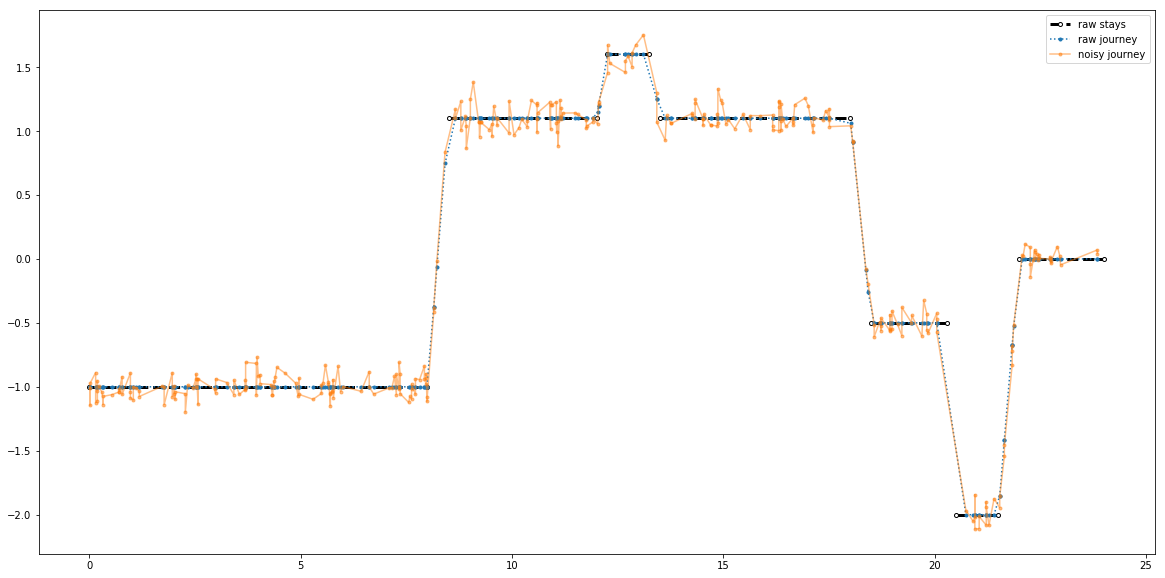

In [569]:
plt.figure(figsize=(20,10))
plt.plot(t_segs, x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='raw stays')
plt.plot(time[cat_mask], raw_journey[cat_mask], '.:', label='raw journey')

noisy_journey = get_noise(raw_journey[cat_mask]) 


plt.plot(time[cat_mask], noisy_journey, '.-', label='noisy journey', alpha=0.5)
plt.legend();